# ResNet - Classificação de Imagens: CIFAR 10

## 1 - Setup

### Install libs

In [1]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#!pip install -q lightning-bolts

### Import libs

In [ ]:
# Sistema e manipulação de arquivos
import os
import warnings
warnings.filterwarnings("ignore")

# Manipulação e processamento de dados
import pandas as pd
import numpy as np
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

# Modelagem
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn

# Avaliação do modelo
from torchmetrics.classification import Accuracy

# Visualização de dados
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns



### Configurando a GPU para processamento

In [3]:
processing_device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_aval = torch.cuda.is_available()

# Definindo o método de processamento.
device = torch.device(processing_device)

In [4]:
# Limpando a memória da GPU
torch.cuda.empty_cache()

In [5]:
# Informações da GPU
#!nvidia-smi

In [6]:
# Definindo seed global
seed_everything(42)

Global seed set to 42


42

In [7]:
# Definindo a quantidade de dados do batch para GPU (quantidade de imagens)
BATCH_SIZE = 256 

# Quantidade de núcleos para paralelização em CPU
NUM_WORKERS = int(os.cpu_count() / 2)

In [8]:
os.cpu_count()

24

## 2 - Load data and Transform

### Pipeline de Transformações de Dados para Treinamento do Modelo

Abaixo estão as transformações de dados aplicadas no pipeline `train_data`:

1. **RandomCrop(32, padding=4)**:
   - Esta transformação realiza um recorte aleatório de uma região de tamanho 32x32 pixels em uma imagem de entrada.
   - Um preenchimento de 4 pixels é aplicado antes do recorte para evitar perda de informação nas bordas da imagem.

2. **RandomHorizontalFlip()**:
   - Esta transformação realiza um espelhamento horizontal aleatório das imagens de entrada com uma probabilidade de 0,5.
   - Isso aumenta a diversidade dos dados de treinamento e ajuda o modelo a aprender invariantes de orientação.

3. **RandomAffine(degrees=0, translate=(0.1, 0.1))**:
   - Esta transformação aplica uma transformação afim aleatória nas imagens de entrada.
   - No caso presente, é aplicada apenas uma translação aleatória de até 10% da largura e altura da imagem.
   - Isso ajuda o modelo a aprender invariantes de posição e aumenta a robustez do modelo em relação a diferentes posições dos objetos nas imagens.

4. **ToTensor()**:
   - Esta transformação converte as imagens de entrada em tensores, que são a estrutura de dados fundamental utilizada pelos modelos de CNN em PyTorch.
   - Os valores dos pixels são normalizados para o intervalo [0, 1].

5. **cifar10_normalization()**:
   - Esta transformação aplica uma normalização específica para o conjunto de dados CIFAR-10.
   - Os valores dos pixels são normalizados para terem média zero e desvio padrão unitário, ajudando na convergência do modelo e tornando-o mais robusto.

Essas etapas de pré-processamento são essenciais para garantir que o modelo seja treinado com dados de qualidade e seja capaz de generalizar bem para novos exemplos.

Os dados de teste não possui todas as etapas de transformação, somente as etapas para coverter o dado para tensor e normalização. Isto porque quero manter o dado de teste como originais para certificar-se que o modelo é capaz de predizer imagens novas.

Este diferença é justamente para evitar overfitting. 

In [9]:
# Tranformação de dados Treino
train_data_pipeline = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        #torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        torchvision.transforms.ToTensor(),
        cifar10_normalization()
    ]
)

# Transformação de dados de Teste
test_data_pipeline = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization()
    ]
)

In [10]:
# Definindo pasta para download dos dados.
PATH_DATASETS = os.environ.get("PATH_DATASETS",'../Data/cifar10')

# Criando pipeline de carga de dados, transformação e separação em treino, test e validação.
load_data = CIFAR10DataModule(data_dir = PATH_DATASETS,
                              batch_size = BATCH_SIZE,
                              num_workers= NUM_WORKERS,
                              train_transforms = train_data_pipeline,
                              test_transforms = test_data_pipeline,
                              val_transforms = test_data_pipeline
                              )

## 3 - Modelos ResNet

### Modelos pre treinados


Modelos pré-treinados são redes neurais que foram treinadas em grandes conjuntos de dados, como o ImageNet, e cujos pesos foram ajustados para reconhecer uma ampla variedade de padrões em imagens naturais. Esses modelos são valiosos porque capturam representações gerais de características visuais úteis, que podem ser transferidas e reutilizadas em tarefas específicas de classificação de imagens.

#### ResNet no PyTorch

O PyTorch oferece implementações dos modelos ResNet pré-treinados através do módulo torchvision.models. A biblioteca inclui várias versões da arquitetura ResNet, como ResNet-18, ResNet-34, ResNet-50, ResNet-101 e ResNet-152. O número após o nome indica o número de camadas na rede.

#### Benefícios dos Modelos Pré-Treinados ResNet

1. **Transfer Learning**: Os modelos pré-treinados ResNet permitem a aplicação de transfer learning, onde os pesos aprendidos em tarefas de classificação de imagens genéricas podem ser transferidos e finamente ajustados para tarefas específicas com conjuntos de dados menores.

2. **Desenvolvimento Eficiente**: Ao utilizar modelos pré-treinados ResNet como base, os desenvolvedores podem economizar tempo e recursos, evitando a necessidade de treinar uma rede neural do zero em grandes conjuntos de dados.

3. **Performance Aprimorada**: Os modelos ResNet são conhecidos por sua eficácia em aprender representações profundas de características visuais, o que muitas vezes se traduz em um desempenho superior em tarefas de classificação de imagens.

#### Como Usar Modelos Pré-Treinados ResNet no PyTorch

Para usar um modelo pré-treinado ResNet em PyTorch, basta importá-lo do módulo `torchvision.models`, instanciá-lo e carregar os pesos pré-treinados. Você pode então utilizar o modelo para inferência ou treinamento adicional em sua tarefa específica.

[Link ResNet PyTorch](https://pytorch.org/vision/main/models/resnet.html)

In [11]:
# Módulo para carregar um modelo pré-treinado de arquitetura ResNet sem os pesos (queremos somente a arquitetura)
def carrega_modelo_pretreinado():
    modelo = torchvision.models.resnet18(weights = None, num_classes = 10)
    modelo.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
    modelo.maxpool = nn.Identity()
    return modelo

In [12]:
# Classe com Arquitetura do Modelo
class ModeloResnet(LightningModule):
    
    # Método construtor
    def __init__(self, lr = 0.05):
        super().__init__()
        self.save_hyperparameters()
        self.model = carrega_modelo_pretreinado()

    # Método Forward
    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim = 1)

    # Método de um passo de treinamento
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    # Método de avaliação
    def evaluate(self, batch, stage = None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim = 1)
        accuracy = Accuracy(task = "multiclass", num_classes = 10).to(device)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar = True)
            self.log(f"{stage}_acc", acc, prog_bar = True)

    # Método de um passo de validação
    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    # Método de um passo de teste
    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    # Método de configuração do otimizador
    def configure_optimizers(self):
        
        # Otimização SGD
        optimizer = torch.optim.SGD(self.parameters(), 
                                    lr = self.hparams.lr, 
                                    momentum = 0.9, 
                                    weight_decay = 5e-4)
        
        # Passos por época
        steps_per_epoch = 45000 // BATCH_SIZE
        
        # Scheduler
        scheduler_dict = {
            "scheduler": OneCycleLR(optimizer,
                                    0.1,
                                    epochs = self.trainer.max_epochs,
                                    steps_per_epoch = steps_per_epoch),
            "interval": "step",
        }
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

### Treinando o modelo

In [13]:
# Módulo de treinamento
treinador = Trainer(max_epochs = 20,
                    accelerator = "auto",
                    devices = 1 if torch.cuda.is_available() else None,  
                    logger = CSVLogger(save_dir = "../models/image_recognition/saved_models/results/logs/"),
                    callbacks = [LearningRateMonitor(logging_interval = "step"), 
                                 TQDMProgressBar(refresh_rate = 10)],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
# Cria o modelo (Objeto = Instância da Classe)
modelo_dl = ModeloResnet(lr = 0.05)

In [15]:
# Treinamento
treinador.fit(modelo_dl, load_data)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [16]:
# Avaliação do Modelo
treinador.test(modelo_dl, datamodule = load_data)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9114000201225281     │
│         test_loss         │    0.2846318483352661     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2846318483352661, 'test_acc': 0.9114000201225281}]

In [17]:
# Carrega as métricas
metricas = pd.read_csv(f"{treinador.logger.log_dir}/metrics.csv")

# Deleta os passos individuais
del metricas["step"]

# Ajusta o índice
metricas.set_index("epoch", inplace = True)

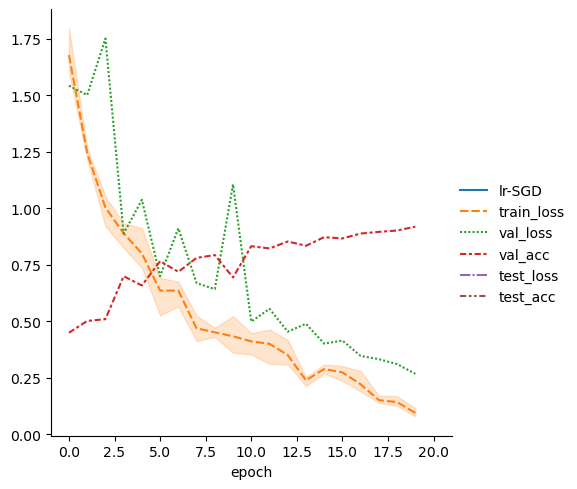

In [18]:
# Resultado
sns.relplot(data = metricas, kind = "line")
plt.show()

In [19]:
# Salvando o modelo 
torch.save(modelo_dl.state_dict(), '../models/image_recognition/saved_models/modelo_dl.pth')